At the end of the experiment:

1.   Generate text which is similar to the writing style of William Shakespeare
2.   Understand how to adapt or tune the trained network

###  Description

The dataset used in this experiment has partial content of different plays of Shakespeare concatenated into a single plain text file. 

Shakespeare is a famous English poet , play writer and actor. He is regarded as the greatest writer in the English language and the world's greatest dramatist. He is often called a England's national poet and the Bard of Avon. 

We have chosen plays of Shakespeare as our dataset mainly for two reasons : 

1. His work is widely recognized as standard for poetry and language.
2. The result of combining of his work provides a sizeable corpus for our model to learn.

The plays of Shakespeare are taken from the following url:

www.opensourceshakespeare.org/views/plays/plays.php


In this experiment we will follow below steps:

1.   Preparing the data
2.   Building the model
3.   Defining helper functions
4.   Training the model
5.    Adapting or Fine-tuning for text generation




Let us start by importing all the required packages to perform this experiment:

In [ ]:
## Importing required packages
import unidecode
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
all_characters = string.printable
## code to find length of all_characters and storing the value in n_characters
n_characters = len(all_characters)
## code to convert unicode characters into plain ASCII.
file = unidecode.unidecode(open('shakespeare.txt').read())
## code to find length of the file
file_len = len(file)
## printing the length of the file
print('file_len =', file_len)

file_len = 1115393


In [ ]:
file[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [ ]:
## Initializing the length of chunk
chunk_len = 200
## Function to split the string into chunks
def random_chunk():
    ## Initializing the starting index value of the big string 
    start_index = random.randint(0, file_len - chunk_len)
    ## Initializing the ending index of the string 
    end_index = start_index + chunk_len + 1
    ## returning the chunk
    return file[start_index:end_index]

print((random_chunk()))

hing-while,
But you must trouble him with lewd complaints.

QUEEN ELIZABETH:
Brother of Gloucester, you mistake the matter.
The king, of his own royal disposition,
And not provoked by any suitor else;



In [ ]:
### Creating recurrent neural network
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    ## tensor is a array
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [ ]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

#### Evaluating

In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

### 4. Training the Model

In [ ]:
## Importing required packages
import time, math
## function to print amount of time passed
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### The main training function

In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        '''unsqueeze() is used to add dimension to the tensor'''
        loss += criterion(output, target[c].unsqueeze(dim=0))
    # Back propagation
    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

In [ ]:
n_epochs = 2000 #Number of epochs
print_every = 50
plot_every = 20
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
## Optimizer
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
## Loss function
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 4s (50 2%) 2.6452]
Whes I lhoms nerr, wand the ure therhich ss ar, fou latd:
Le dree:
A:
This freath ch le louhek, Iig, l 

 8s (100 5%) 2.3658]
Whe ag wee the sakos oure thoun: agce sow thest of tae iour my noter thing in the an this angedst oter 

 13s (150 7%) 2.5844]
Whourt.

LUS:
What that thow,
Is ver?
Bodow, thy wa fard of firtipt
O, I wil speer theroundy he er cov 

 17s (200 10%) 2.1372]
Why, whost bomqus by theal afle onted oure sord hat thav arouth that you theage shongmeall woul amace  

 22s (250 12%) 2.0028]
Whoubllass beaked
I pe nall to the trith he stre tore hare, ge low, he, thy he lall hich wesfiar,
Ward 

 26s (300 15%) 2.2574]
Whan: that nov to to shere blighthe are me day haren to they my it to thy the arak,
wran wing'd
Foon,
 

 30s (350 17%) 2.2111]
Wher it in in thou forrs.
Titill hall sstond pagnous hang.

Slors forsht hall the ther norne. wand the 

 34s (400 20%) 2.0980]
Whert iver, hald ther the groonous ave the cones to now, sumes, herory thar bear, and
y

#### Plotting the Training Losses

Text(0, 0.5, 'loss')

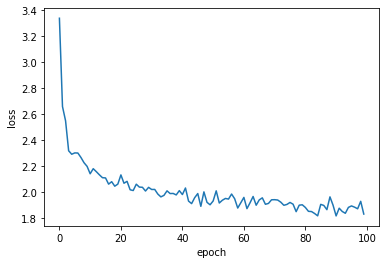

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.xlabel("epoch")
plt.ylabel("loss")

We can see the effects of this by adjusting the temperature argument:

In [ ]:
print(evaluate('u', 200, temperature=0.8))

ur the sour yough,
And what nawn a toe it
Wears,
To And he but make with of and leabrack,
Beptake that awake ur, and make that with to man sirk love the like make this the lord, a where be the own we i


Lower temperatures are less varied, choosing only the more probable outputs:

In [ ]:
print(evaluate('Th', 200, temperature=0.2))

The like the with the be the last the make the king the stalt the be a do the known the state a love the make the state, a with of the with a the lord, and the with the make the love the love the state 



Higher temperatures more varied, choosing less probable outputs:

In [ ]:
print(evaluate('how', 200, temperature=1.4))

howneds? Go-condcupatierple knows, no ot:
Aptles, the lustlend oftakiak,
A't
Ully caste, thou
tathan taBus-thee Hisetoqut!
In af;
And letoor:
Bud dosted than throes!
Ands jear thee-k, wrofe; che'd,

TISF
